In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving CMBD_AE.feather to CMBD_AE.feather
User uploaded file "CMBD_AE.feather" with length 7872938 bytes


#Carga de librerías

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import scipy.stats as stats
import seaborn as sns
import sklearn
import xgboost
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
!pip install category_encoders
import category_encoders as ce
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_selector
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset = pd.read_feather('CMBD_AE.feather')
dataset.head(5)


,ID_SIP_ANONIMIZADO,CMBD,FECNAC,SEXO,PAIS_NAC,RESIDE_CP,RESIDE_MUNI,REGFIN,FECINICONT,FECING,...,M3,M4,M5,M6,CEN_SAN,CCAA,ICU,MEDICO,PROCEDE,TRASLADO
0,1462624,HADO,1972-05-20,Varon,724,35400,350069,Sistema Nacional de Salud,2017-07-25,NaT,...,NaN,NaN,NaN,NaN,350311,05,2017672358309,MPONGONX,NaN,NaN
1,164450,HADO,1933-11-05,Varon,724,35000,350167,Sistema Nacional de Salud,2017-08-30,NaT,...,NaN,NaN,NaN,NaN,350311,05,2017672558195,LSALREI,NaN,NaN
2,300010,HADO,1931-09-01,Varon,724,35008,350167,Sistema Nacional de Salud,2016-12-27,NaT,...,NaN,NaN,NaN,NaN,350311,05,2016663114435,MPONGONX,NaN,NaN
3,272961,HADO,1958-12-28,Varon,724,35000,350167,Sistema Nacional de Salud,2017-07-27,NaT,...,NaN,NaN,NaN,NaN,350311,05,2017672374848,LFALPERS,NaN,NaN
4,289808,HADO,1948-01-01,Mujer,504,35000,350167,Sistema Nacional de Salud,2017-01-25,NaT,...,NaN,NaN,NaN,NaN,350311,05,2017671137078,GBAUSUA,NaN,NaN


#Procesamiento de datos

In [ ]:
print('El conjunto de datos "dataset" contiene', dataset.shape[1], 'columnas y', dataset.shape[0], 'filas')

El conjunto de datos "dataset" contiene 99 columnas y 337061 filas


In [ ]:
#Información de las columnas
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337061 entries, 0 to 337060
Data columns (total 99 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   ID_SIP_ANONIMIZADO       337061 non-null  uint32        
 1   CMBD                     337061 non-null  category      
 2   FECNAC                   337061 non-null  datetime64[ns]
 3   SEXO                     337061 non-null  category      
 4   PAIS_NAC                 337061 non-null  category      
 5   RESIDE_CP                331452 non-null  category      
 6   RESIDE_MUNI              331533 non-null  category      
 7   REGFIN                   337061 non-null  category      
 8   FECINICONT               337061 non-null  datetime64[ns]
 9   FECING                   33178 non-null   datetime64[ns]
 10  TIPCONT                  337061 non-null  category      
 11  TIPVISITA                337061 non-null  category      
 12  PROCEDENCIA     

Valores únicos en la variable referente a los ID de los pacientes y en las variables categóricas.

In [ ]:
dataset['ID_SIP_ANONIMIZADO'].nunique()

123150

In [ ]:
dataset.select_dtypes(include='category').nunique()

CMBD             5
SEXO             2
PAIS_NAC       128
RESIDE_CP      485
RESIDE_MUNI    420
              ... 
CEN_SAN          1
CCAA             1
MEDICO         967
PROCEDE         13
TRASLADO        28
Length: 90, dtype: int64

Categorización numérica de la variable TIPING y eliminación de categorías no interesantes en el estudio.

In [ ]:
datos = dataset.copy()


In [ ]:
datos = datos[~datos['TIPING'].isin(['Desconocido'])]

Nos quedamos solo con los episodios de actividad hospitalaria (CMBD) referidos a hospitalizaciones (H).

In [ ]:
datos = datos[datos['CMBD'] == 'H']
print(datos)

        ID_SIP_ANONIMIZADO CMBD     FECNAC   SEXO PAIS_NAC RESIDE_CP  \
215451             2963152    H 1943-01-26  Varon       68     35009   
215452             1311990    H 1926-08-08  Varon      724     35400   
215453             4104507    H 1968-08-16  Varon      620     35018   
215454              303759    H 1959-11-05  Varon      724     35012   
215455              261582    H 1926-05-15  Mujer      724     35300   
...                    ...  ...        ...    ...      ...       ...   
278811              311868    H 1959-05-11  Varon      724     35005   
278812              163265    H 1993-01-23  Varon      724     35400   
278813              268495    H 1945-04-20  Mujer      724     35300   
278814              111343    H 1934-12-25  Varon      724     35330   
278815              152355    H 1980-12-19  Mujer      724     35018   

       RESIDE_MUNI                     REGFIN FECINICONT     FECING  ...   M3  \
215451      350167  Sistema Nacional de Salud 2017-04-

Comprobación de la cantidad de datos tras los primeros cambios

In [ ]:
datos.shape

(58964, 99)

In [ ]:
datos['ID_SIP_ANONIMIZADO'].nunique()

36689

Frecuencia relativa de ingresos no programados.

In [ ]:
freqrel_TIPING = datos['TIPING'].value_counts(normalize=True)
print(freqrel_TIPING)

No programado    0.612713
Programado       0.387287
Desconocido      0.000000
Name: TIPING, dtype: float64


Creación de nuevas variables

In [ ]:
datos['Edad'] = (datos['FECINICONT'] - datos['FECNAC']).astype('<m8[Y]')
datos = datos.drop(columns='FECNAC')

In [ ]:
#Utilizar solo cuando sea necesario
#nombre_archivo_excel = "mi_dataset.xlsx"

# Guarda el DataFrame en un archivo Excel
#datos.to_excel(nombre_archivo_excel, index=False)

In [ ]:
# Ordenación del conjunto de datos por "ID" y "Fecha_Ingreso"
datos.sort_values(by=['ID_SIP_ANONIMIZADO', 'FECINICONT'], inplace=True)

# Calcular la diferencia de fechas para cada ID
datos['Dias_Transcurridos'] = datos.groupby('ID_SIP_ANONIMIZADO')['FECFINCONT'].diff().dt.days

# Los pacientes que no tienen un nuevo ingreso tendrán NaN en "Dias_Transcurridos". Se remplazan los NaN por 0
datos['Dias_Transcurridos'].fillna(0, inplace=True)
datos['Dias_Transcurridos'] = datos['Dias_Transcurridos'].astype('int64')

print(datos)


        ID_SIP_ANONIMIZADO CMBD   SEXO PAIS_NAC RESIDE_CP RESIDE_MUNI  \
228425                1069    H  Mujer      724     35000      350167   
256419                1451    H  Mujer      724     35470      350206   
231989                1532    H  Mujer      724     35450      357530   
229911                1579    H  Mujer      724     35470      350206   
250013                1582    H  Varon      724     35430      350081   
...                    ...  ...    ...      ...       ...         ...   
250981             4392635    H  Varon      724     35018      350167   
253291             4427509    H  Varon       32     35011      350167   
247922             4432258    H  Varon      724     35488      350094   
251819             4435035    H  Mujer       32     35010      350167   
252730             4479283    H  Varon      340     35458      352610   

                           REGFIN FECINICONT     FECING          TIPCONT  ...  \
228425  Sistema Nacional de Salud 2016-06-

Fechas

In [ ]:
datos['FECINICONT'].min()

Timestamp('2016-01-01 00:00:00')

In [ ]:
datos['FECINICONT'].max()

Timestamp('2019-12-30 00:00:00')

In [ ]:
columnas_fecha = datos.select_dtypes(include=['datetime64']).columns

# Elimina las columnas de fecha del DataFrame
datos = datos.drop(columns=columnas_fecha)

Número de reingresos

In [ ]:
conteo_apariciones = datos['ID_SIP_ANONIMIZADO'].value_counts()

ids_con_reingreso = conteo_apariciones[conteo_apariciones > 1].index.tolist()

print(len(ids_con_reingreso))

11935


Es necesario crear una variable etiqueta con los datos de pacientes con reingreso hospitalario. Será una variable dummy.

In [ ]:
datos['Etiqueta'] = datos.apply(lambda row: 1 if (0 < row['Dias_Transcurridos'] < 30 and row['TIPING'] == 'No programado') else 0, axis=1)

In [ ]:
contador = (datos['Etiqueta'] == 1).sum()

print("Cantidad reingresos anteriores a los 30 días':", contador)

Cantidad reingresos anteriores a los 30 días': 2367


In [ ]:
freqrel_ETIQUETA = datos['Etiqueta'].value_counts(normalize=True)
print(freqrel_ETIQUETA)

0    0.959857
1    0.040143
Name: Etiqueta, dtype: float64


Rango de edad de lso pacientes (Mínimo y máximo)

In [ ]:
datos.loc[datos['Etiqueta'] == 1, 'Edad'].min()

15.0

In [ ]:
datos.loc[datos['Etiqueta'] == 1, 'Edad'].max()

104.0

Conversión de variables categóricas

In [ ]:
datos['ID_SIP_ANONIMIZADO'] = datos['ID_SIP_ANONIMIZADO'].astype('category')

In [ ]:
for col in datos.select_dtypes(include='object' and 'category'):
  label_encoder=LabelEncoder()
  label_encoder.fit(datos[col].unique())
  datos[col]=label_encoder.transform(datos[col])

Eliminación de variables no necesarias en el estudio

In [ ]:
eliminar = ['PAIS_NAC', 'RESIDE_CP', 'RESIDE_MUNI', 'TIPCONT', 'TIPVISITA','CMBD', 'SERVICIO_ALTA', 'DIAS_UCI', 'CEN_SAN','CCAA','ICU', 'PROCEDE', 'TRASLADO', 'Dias_Transcurridos']
datos = datos.drop(eliminar, axis=1)

Reemplazo de valores faltantes

In [ ]:
datos.isnull().sum()

ID_SIP_ANONIMIZADO    0
SEXO                  0
REGFIN                0
PROCEDENCIA           0
TIPING                0
                     ..
M5                    0
M6                    0
MEDICO                0
Edad                  0
Etiqueta              0
Length: 83, dtype: int64

In [ ]:
imputador = KNNImputer(n_neighbors=3)
datos_imputados = imputador.fit_transform(datos)

datos = pd.DataFrame(datos_imputados, columns=datos.columns)

In [ ]:
datos = datos.astype('int64')

Visionado del conjunto de datos ya preparado.

In [ ]:
datos.head(10)

,ID_SIP_ANONIMIZADO,SEXO,REGFIN,PROCEDENCIA,TIPING,TIPALT,DISPOSITIVO_CONTINUIDAD,UCI,D1,POAD1,...,PROCEXT6,M1,M2,M3,M4,M5,M6,MEDICO,Edad,Etiqueta
0,0,0,5,0,1,2,1,0,117,4,...,0,496,235,71,19,1,0,312,57,0
1,1,0,5,0,1,2,1,0,855,4,...,0,496,235,71,19,1,0,199,65,0
2,2,0,5,6,0,2,1,0,4513,5,...,0,496,235,71,19,1,0,478,81,0
3,3,0,5,6,0,6,2,0,20,4,...,0,496,235,71,19,1,0,406,30,0
4,4,1,5,0,1,2,1,0,3168,4,...,0,496,235,71,19,1,0,443,80,0
5,5,0,5,0,1,2,1,0,2719,4,...,0,496,235,71,19,1,0,225,71,0
6,6,1,5,0,1,2,1,0,1501,4,...,0,496,235,71,19,1,0,250,63,0
7,7,0,5,6,0,2,1,0,4054,4,...,0,496,235,71,19,1,0,225,28,0
8,8,1,5,6,0,2,1,0,2015,4,...,0,496,235,71,19,1,0,144,82,0
9,9,0,5,6,0,4,0,1,1263,4,...,0,496,235,71,19,1,0,224,72,0


In [ ]:
datos.select_dtypes(include='int64').nunique()

ID_SIP_ANONIMIZADO    36689
SEXO                      2
REGFIN                    6
PROCEDENCIA               8
TIPING                    2
                      ...  
M5                        2
M6                        1
MEDICO                  500
Edad                     93
Etiqueta                  2
Length: 83, dtype: int64

Análisis descriptivo según la variable objetivo 'Etiqueta'

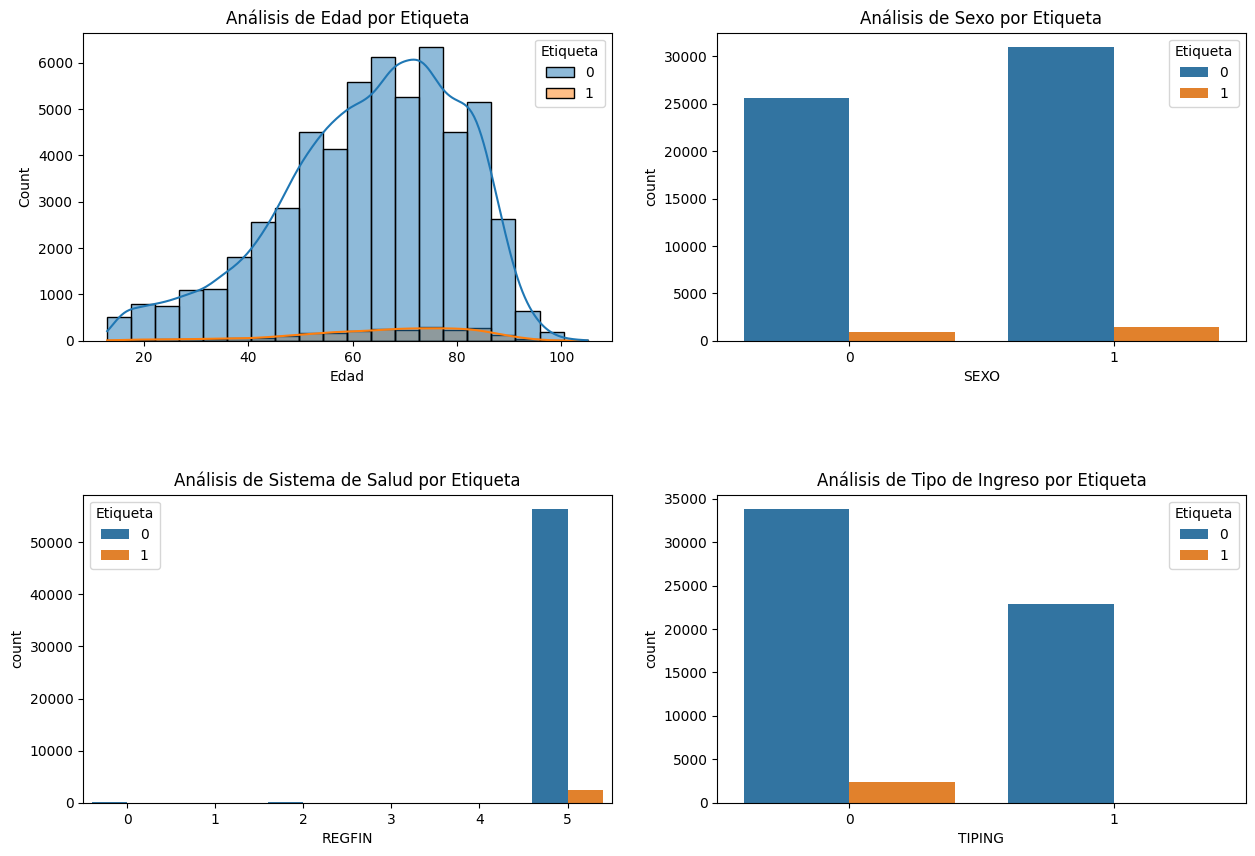

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

# Gráfico 1: Análisis de edad
plt.subplot(2, 2, 1)
sns.histplot(data=datos, x='Edad', bins=20, kde=True, hue='Etiqueta')
plt.title('Análisis de Edad por Etiqueta')

# Gráfico 2: Análisis de sexo
plt.subplot(2, 2, 2)
sns.countplot(data=datos, x='SEXO', hue='Etiqueta')
plt.title('Análisis de Sexo por Etiqueta')

# Gráfico 3: Análisis de CMBD
plt.subplot(2, 2, 3)
sns.countplot(data=datos, x='REGFIN', hue='Etiqueta')
plt.title('Análisis de Sistema de Salud por Etiqueta')

# Gráfico 5: Análisis de tipo de ingreso
plt.subplot(2, 2, 4)
sns.countplot(data=datos, x='TIPING', hue='Etiqueta')
plt.title('Análisis de Tipo de Ingreso por Etiqueta')


# Mostrar los gráficos
plt.show()

##Correlaciones

In [ ]:
threshold = 0.7

# Calcular las correlaciones
correlation_matrix = datos.corr()

# Identificar las correlaciones significativas
significant_correlations = (correlation_matrix.abs() > threshold) & (correlation_matrix != 1)

# Crear una lista de variables con correlaciones significativas
variables_significativas = []

# Iterar a través de la matriz de correlación y agregar las variables relacionadas
for variable in significant_correlations.columns:
    relacionadas = correlation_matrix.index[significant_correlations[variable]].tolist()
    if relacionadas:
        variables_significativas.append((variable, relacionadas))

# Imprimir la lista de variables con correlaciones significativas
for variable, relacionadas in variables_significativas:
    print(f"Variable: {variable} - Correlacionada con: {', '.join(relacionadas)}")

Variable: PROCEDENCIA - Correlacionada con: TIPING
Variable: TIPING - Correlacionada con: PROCEDENCIA
Variable: D11 - Correlacionada con: D12
Variable: D12 - Correlacionada con: D11
Variable: D13 - Correlacionada con: D14
Variable: D14 - Correlacionada con: D13, D15
Variable: D15 - Correlacionada con: D14, D16
Variable: D16 - Correlacionada con: D15, D17
Variable: D17 - Correlacionada con: D16, D18
Variable: D18 - Correlacionada con: D17, D19
Variable: D19 - Correlacionada con: D18, D20
Variable: D20 - Correlacionada con: D19
Variable: POAD14 - Correlacionada con: POAD15
Variable: POAD15 - Correlacionada con: POAD14, POAD16
Variable: POAD16 - Correlacionada con: POAD15, POAD17
Variable: POAD17 - Correlacionada con: POAD16, POAD18
Variable: POAD18 - Correlacionada con: POAD17, POAD19
Variable: POAD19 - Correlacionada con: POAD18, POAD20
Variable: POAD20 - Correlacionada con: POAD19
Variable: PROC13 - Correlacionada con: PROC14
Variable: PROC14 - Correlacionada con: PROC13
Variable: PROC

In [ ]:
eliminar2 = ['D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'POAD14','POAD15', 'POAD16', 'POAD17', 'POAD18','POAD19', 'POAD20',
            'PROC13', 'PROC14', 'PROC15', 'PROC16', 'PROC17', 'PROC18']
datos = datos.drop(eliminar2, axis=1)

In [ ]:
print('El conjunto de datos final contiene', datos.shape[1], 'columnas y', datos.shape[0], 'filas', 'con', datos['ID_SIP_ANONIMIZADO'].nunique(), 'pacientes')

El conjunto de datos final contiene 60 columnas y 58964 filas con 36689 pacientes


#Creación del modelo
## División Train Test

In [ ]:
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from imblearn.over_sampling import SMOTE

# X serían las características, y variable objetivo
X = datos.drop(columns=['ID_SIP_ANONIMIZADO'])
y = datos['Etiqueta']

# Crea una instancia de GroupShuffleSplit
group_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Divide los datos en conjuntos de entrenamiento y prueba
for train_idx, test_idx in group_splitter.split(X, y, groups=datos['ID_SIP_ANONIMIZADO']):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Aplica el sobremuestreo solo al conjunto de entrenamiento
smote = SMOTE(sampling_strategy='auto')  # Puedes ajustar la estrategia según tus necesidades
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Divide el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.4, random_state=42)

# Ahora, tienes X_train, y_train (entrenamiento con sobremuestreo), X_val, y_val (validación) y X_test, y_test (prueba).


In [ ]:
print(f"Número de observaciones en el conjunto de entrenamiento: {len(X_train)}")
print(f"Número de observaciones en el conjunto de prueba: {len(X_test)}")
print(f"Número de observaciones en el conjunto de validación: {len(X_val)}")

Número de observaciones en el conjunto de entrenamiento: 54372
Número de observaciones en el conjunto de prueba: 11753
Número de observaciones en el conjunto de validación: 36248


In [ ]:
# Calcular la frecuencia relativa de la categoría 1 en la partición de entrenamiento (train)
frecuencia_train = X_train['Etiqueta'].value_counts(normalize=True).get(1, 0)
print(f"Frecuencia relativa de la categoría 1 en train: {frecuencia_train:.2%}")

# Calcular la frecuencia relativa de la categoría 1 en la partición de prueba (test)
frecuencia_test = X_test['Etiqueta'].value_counts(normalize=True).get(1, 0)
print(f"Frecuencia relativa de la categoría 1 en test: {frecuencia_test:.2%}")

# Calcular la frecuencia relativa de la categoría 1 en la partición de validación (val)
frecuencia_val = X_val['Etiqueta'].value_counts(normalize=True).get(1, 0)
print(f"Frecuencia relativa de la categoría 1 en val: {frecuencia_val:.2%}")


Frecuencia relativa de la categoría 1 en train: 50.01%
Frecuencia relativa de la categoría 1 en test: 3.96%
Frecuencia relativa de la categoría 1 en val: 49.98%


In [ ]:
# Elimina la variable "Etiqueta" de X_train
X_train.drop(columns=['Etiqueta'], inplace=True)

# Elimina la variable "Etiqueta" de X_val
X_val.drop(columns=['Etiqueta'], inplace=True)

# Elimina la variable "Etiqueta" de X_test
X_test.drop(columns=['Etiqueta'], inplace=True)

<ipython-input-27-f2aa49748617>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns=['Etiqueta'], inplace=True)


##Estandarización de los conjuntos de datos

In [ ]:
# Inicializa un objeto StandardScaler
scaler = StandardScaler()

# Ajusta el scaler al conjunto de entrenamiento y estandariza X_train
X_train = scaler.fit_transform(X_train)

# Utiliza los mismos parámetros de estandarización para transformar X_test
X_test = scaler.transform(X_test)

# Utiliza los mismos parámetros de estandarización para transformar X_val
X_val = scaler.transform(X_val)


## Regresión logísitca

###Mejores hiperparámetros

In [ ]:
#Realizar un ciclo iterativo de optimización en el conjunto de validación:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
logreg = LogisticRegression(solver='liblinear')
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_val, y_val)
best_params = grid_search.best_params_

#Entrenar el modelo con los mejores hiperparámetros:
best_C = best_params['C']


###Entrenamiento del modelo

In [ ]:
logreg_final = LogisticRegression(C=best_C, solver='liblinear').fit(X_train, y_train)

###Evaluación del modelo

In [ ]:
# Evaluar el rendimiento en el conjunto de prueba.
pred_logreg = logreg_final.predict(X_test)

accuracy_logreg = accuracy_score(y_test, pred_logreg)
precision_logreg = precision_score(y_test, pred_logreg)
recall_logreg = recall_score(y_test, pred_logreg)
f1_score_logreg = f1_score(y_test, pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, pred_logreg)
matriz_confusion_logreg = confusion_matrix(y_test, pred_logreg)

print("Métricas conjunto entrenamiento:")
print(f"Exactitud (Accuracy): {accuracy_logreg:.4f}")
print(f"Precisión: {precision_logreg:.4f}")
print(f"Recall: {recall_logreg:.4f}")
print(f"Puntuación F1: {f1_score_logreg:.4f}")
print(f"AUC-ROC: {roc_auc_logreg:.4f}")
print("Matriz de Confusión:")
print(matriz_confusion_logreg)

Métricas conjunto entrenamiento:
Exactitud (Accuracy): 0.7102
Precisión: 0.0880
Recall: 0.6738
Puntuación F1: 0.1557
AUC-ROC: 0.6928
Matriz de Confusión:
[[8033 3254]
 [ 152  314]]


####Visualización de curva ROC

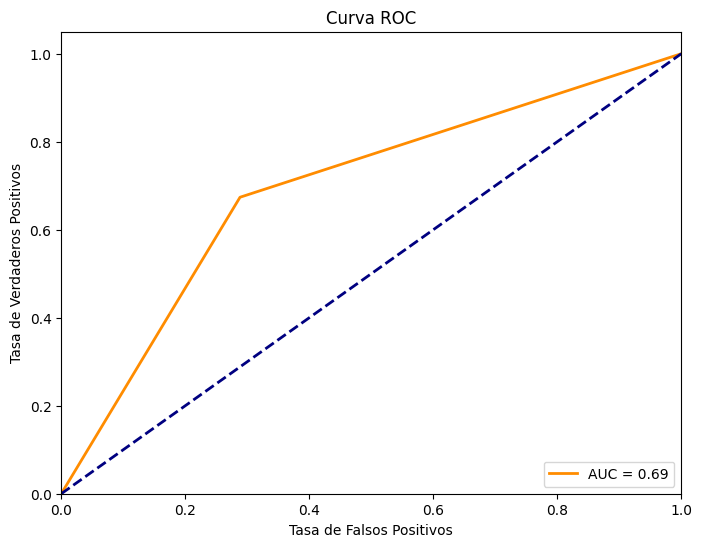

In [ ]:
fpr, tpr, _ = roc_curve(y_test, pred_logreg)

# Calcula el AUC-ROC
roc_auc = auc(fpr, tpr)

# Dibuja la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

###Análisis de resultados

In [ ]:
print(classification_report(y_test, pred_logreg))

              precision    recall  f1-score   support

           0       0.98      0.71      0.83     11287
           1       0.09      0.67      0.16       466

    accuracy                           0.71     11753
   macro avg       0.53      0.69      0.49     11753
weighted avg       0.95      0.71      0.80     11753



###Predicción de casos de riesgo

In [ ]:
pred_logreg_riesgo = logreg_final.predict(X_test)

# Establecer un umbral para definir "alto riesgo" (por ejemplo, 0.7)
umbral = 0.7
casos_alto_riesgo = (pred_logreg_riesgo > umbral)

# Evaluar el rendimiento del modelo en el conjunto de prueba completo
precision = precision_score(y_test, pred_logreg_riesgo > umbral)
recall = recall_score(y_test, pred_logreg_riesgo > umbral)
f1 = f1_score(y_test, pred_logreg_riesgo > umbral)
confusion = confusion_matrix(y_test, pred_logreg_riesgo > umbral)

# Imprimir los resultados
print(f"Casos de alto riesgo identificados: {casos_alto_riesgo.sum()}")
print(f"Precisión en casos de alto riesgo: {precision:.2f}")
print(f"Recall en casos de alto riesgo: {recall:.2f}")
print(f"Puntuación F1 en casos de alto riesgo: {f1:.2f}")
print("Matriz de Confusión en casos de alto riesgo:")
print(confusion)

Casos de alto riesgo identificados: 3568
Precisión en casos de alto riesgo: 0.09
Recall en casos de alto riesgo: 0.67
Puntuación F1 en casos de alto riesgo: 0.16
Matriz de Confusión en casos de alto riesgo:
[[8033 3254]
 [ 152  314]]


##kNN

###Mejor valor de k

In [ ]:
k_range = range(1, 11)
best_k = None
best_score = 0

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    if score > best_score:
        best_score = score
        best_k = k

print(f"Mejor valor de 'k' en el conjunto de validación: {best_k} con una precisión de {best_score:.4f}")

Mejor valor de 'k' en el conjunto de validación: 2 con una precisión de 0.9438


###Entrenamiento del modelo

In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)

###Evaluación del modelo

In [ ]:
pred_knn = knn_final.predict(X_test)

accuracy_knn = accuracy_score(y_test, pred_knn)
precision_knn = precision_score(y_test, pred_knn)
recall_knn = recall_score(y_test, pred_knn)
f1_score_knn = f1_score(y_test, pred_knn)
roc_auc_knn = roc_auc_score(y_test, pred_knn)
matriz_confusion_knn = confusion_matrix(y_test, pred_knn)

print("Métricas en el conjunto de validación:")
print(f"Exactitud (Accuracy): {accuracy_knn:.4f}")
print(f"Precisión: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"Puntuación F1: {f1_score_knn:.4f}")
print(f"AUC-ROC: {roc_auc_knn:.4f}")
print("Matriz de Confusión:")
print(matriz_confusion_knn)

Métricas en el conjunto de validación:
Exactitud (Accuracy): 0.8799
Precisión: 0.0929
Recall: 0.2318
Puntuación F1: 0.1327
AUC-ROC: 0.5692
Matriz de Confusión:
[[10233  1054]
 [  358   108]]


####Visualización de curva ROC

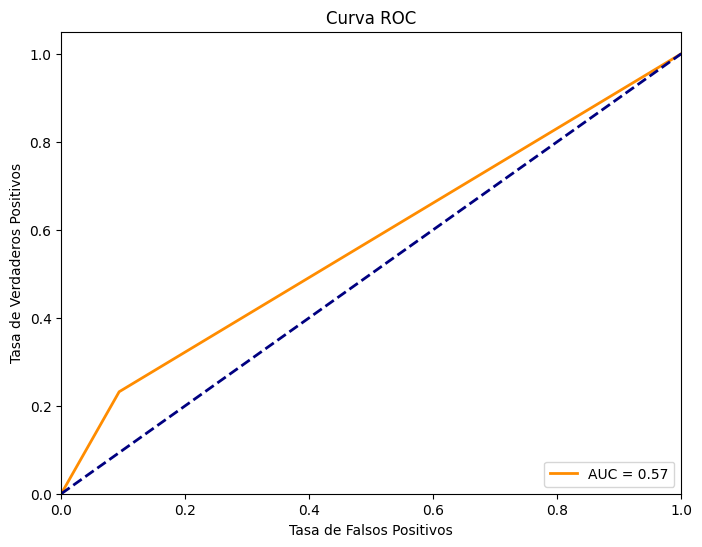

In [ ]:
fpr, tpr, _ = roc_curve(y_test, pred_knn)

# Calcula el AUC-ROC
roc_auc = auc(fpr, tpr)

# Dibuja la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

###Análisis de resultados

In [ ]:
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     11287
           1       0.09      0.23      0.13       466

    accuracy                           0.88     11753
   macro avg       0.53      0.57      0.53     11753
weighted avg       0.93      0.88      0.90     11753



###Predicción de casos de riesgo

In [ ]:
pred_knn_riesgo = knn_final.predict(X_test)

# Establecer un umbral para definir "alto riesgo" (por ejemplo, 0.7)
umbral = 0.7
casos_alto_riesgo = (pred_knn_riesgo > umbral)

# Evaluar el rendimiento del modelo en el conjunto de prueba completo
precision = precision_score(y_test, pred_knn_riesgo > umbral)
recall = recall_score(y_test, pred_knn_riesgo > umbral)
f1 = f1_score(y_test, pred_knn_riesgo > umbral)
confusion = confusion_matrix(y_test, pred_knn_riesgo > umbral)

# Imprimir los resultados
print(f"Casos de alto riesgo identificados: {casos_alto_riesgo.sum()}")
print(f"Precisión en casos de alto riesgo: {precision:.2f}")
print(f"Recall en casos de alto riesgo: {recall:.2f}")
print(f"Puntuación F1 en casos de alto riesgo: {f1:.2f}")
print("Matriz de Confusión en casos de alto riesgo:")
print(confusion)

Casos de alto riesgo identificados: 1162
Precisión en casos de alto riesgo: 0.09
Recall en casos de alto riesgo: 0.23
Puntuación F1 en casos de alto riesgo: 0.13
Matriz de Confusión en casos de alto riesgo:
[[10233  1054]
 [  358   108]]


##Random Forest

###Mejores hiperparámetros

In [ ]:
#Ciclo iterativo de optimización en el conjunto de validación.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_val, y_val)
best_params = grid_search.best_params_
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']


In [ ]:
print(best_n_estimators, best_max_depth, best_min_samples_split, best_min_samples_leaf)

300 None 2 1


###Entrenamiento del modelo

In [ ]:
rf_final = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42).fit(X_train, y_train)


###Evaluación del modelo

In [ ]:
pred_rf = rf_final.predict(X_test)

accuracy_rf = accuracy_score(y_test, pred_rf)
precision_rf = precision_score(y_test, pred_rf)
recall_rf = recall_score(y_test, pred_rf)
f1_score_rf = f1_score(y_test, pred_rf)
roc_auc_rf = roc_auc_score(y_test, pred_rf)
matriz_confusion_rf = confusion_matrix(y_test, pred_rf)

print("Métricas en el conjunto de validación:")
print(f"Exactitud (Accuracy): {accuracy_rf:.4f}")
print(f"Precisión: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"Puntuación F1: {f1_score_rf:.4f}")
print(f"AUC-ROC: {roc_auc_rf:.4f}")
print("Matriz de Confusión:")
print(matriz_confusion_rf)

Métricas en el conjunto de validación:
Exactitud (Accuracy): 0.9309
Precisión: 0.1594
Recall: 0.1738
Puntuación F1: 0.1663
AUC-ROC: 0.5680
Matriz de Confusión:
[[10860   427]
 [  385    81]]


####Visualización de curva ROC

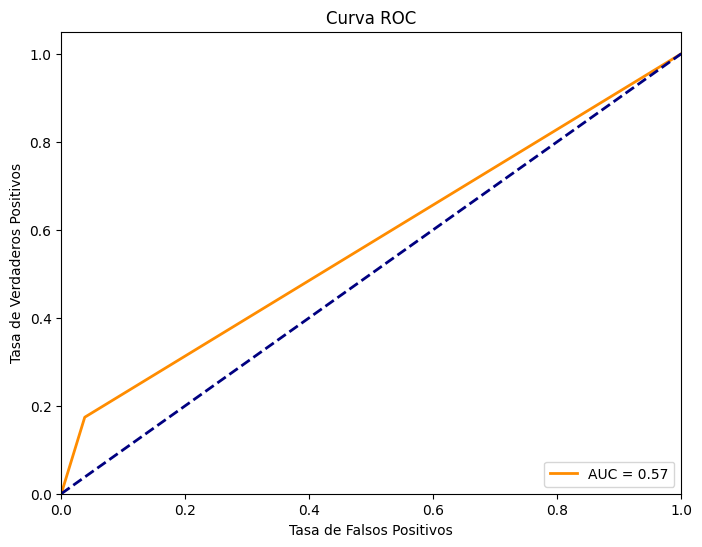

In [ ]:
fpr, tpr, _ = roc_curve(y_test, pred_rf)

# Calcula el AUC-ROC
roc_auc = auc(fpr, tpr)

# Dibuja la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

###Análisis de resultados

In [ ]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     11287
           1       0.16      0.17      0.17       466

    accuracy                           0.93     11753
   macro avg       0.56      0.57      0.57     11753
weighted avg       0.93      0.93      0.93     11753



###Predicción casos de alto riesgo

In [ ]:
pred_rf_riesgo = rf_final.predict(X_test)

# Establecer un umbral para definir "alto riesgo" (por ejemplo, 0.7)
umbral = 0.7
casos_alto_riesgo = (pred_rf_riesgo > umbral)

# Evaluar el rendimiento del modelo en el conjunto de prueba completo
precision = precision_score(y_test, pred_rf_riesgo > umbral)
recall = recall_score(y_test, pred_rf_riesgo > umbral)
f1 = f1_score(y_test, pred_rf_riesgo > umbral)
confusion = confusion_matrix(y_test, pred_rf_riesgo > umbral)

# Imprimir los resultados
print(f"Casos de alto riesgo identificados: {casos_alto_riesgo.sum()}")
print(f"Precisión en casos de alto riesgo: {precision:.2f}")
print(f"Recall en casos de alto riesgo: {recall:.2f}")
print(f"Puntuación F1 en casos de alto riesgo: {f1:.2f}")
print("Matriz de Confusión en casos de alto riesgo:")
print(confusion)

Casos de alto riesgo identificados: 508
Precisión en casos de alto riesgo: 0.16
Recall en casos de alto riesgo: 0.17
Puntuación F1 en casos de alto riesgo: 0.17
Matriz de Confusión en casos de alto riesgo:
[[10860   427]
 [  385    81]]


##XGBoost

###Mejores hiperparámetros

In [ ]:
#Ciclo iterativo de optimización en el conjunto de validación.
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 2, 3]}

xgboost = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgboost, param_grid, cv=5)
grid_search.fit(X_val, y_val)
best_params = grid_search.best_params_
best_learning_rate = best_params['learning_rate']
best_max_depth = best_params['max_depth']
best_n_estimators = best_params['n_estimators']
best_min_child_weight = best_params['min_child_weight']

In [ ]:
print(best_learning_rate, best_max_depth, best_n_estimators, best_min_child_weight)

0.2 5 300 1


###Entrenamiento del modelo

In [ ]:
xgboost_final = XGBClassifier(
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    n_estimators=best_n_estimators,
    min_child_weight=best_min_child_weight,
    random_state=42).fit(X_train, y_train)


###Evaluación del modelo

In [ ]:
pred_xgboost = xgboost_final.predict(X_test)

accuracy_xgboost = accuracy_score(y_test, pred_xgboost)
precision_xgboost = precision_score(y_test, pred_xgboost)
recall_xgboost = recall_score(y_test, pred_xgboost)
f1_score_xgboost = f1_score(y_test, pred_xgboost)
roc_auc_xgboost = roc_auc_score(y_test, pred_xgboost)
matriz_confusion_xgboost = confusion_matrix(y_test, pred_xgboost)

print("Métricas en el conjunto de validación:")
print(f"Exactitud (Accuracy): {accuracy_xgboost:.4f}")
print(f"Precisión: {precision_xgboost:.4f}")
print(f"Recall: {recall_xgboost:.4f}")
print(f"Puntuación F1: {f1_score_xgboost:.4f}")
print(f"AUC-ROC: {roc_auc_xgboost:.4f}")
print("Matriz de Confusión:")
print(matriz_confusion_xgboost)

Métricas en el conjunto de validación:
Exactitud (Accuracy): 0.9381
Precisión: 0.2009
Recall: 0.1888
Puntuación F1: 0.1947
AUC-ROC: 0.5789
Matriz de Confusión:
[[10937   350]
 [  378    88]]


####Visualización de curva ROC

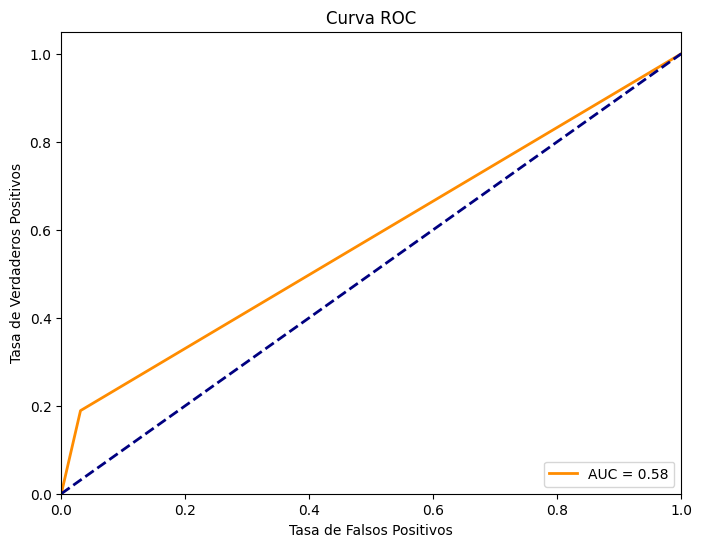

In [ ]:
fpr, tpr, _ = roc_curve(y_test, pred_xgboost)

# Calcula el AUC-ROC
roc_auc = auc(fpr, tpr)

# Dibuja la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

###Análisis de resultados

In [ ]:
print(classification_report(y_test, pred_xgboost))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11287
           1       0.20      0.19      0.19       466

    accuracy                           0.94     11753
   macro avg       0.58      0.58      0.58     11753
weighted avg       0.94      0.94      0.94     11753



###Predicción de casos de riesgo

In [ ]:
pred_xgboost_riesgo = xgboost_final.predict(X_test)

# Establecer un umbral para definir "alto riesgo" (por ejemplo, 0.7)
umbral = 0.7
casos_alto_riesgo = (pred_xgboost_riesgo > umbral)

# Evaluar el rendimiento del modelo en el conjunto de prueba completo
precision = precision_score(y_test, pred_xgboost_riesgo > umbral)
recall = recall_score(y_test, pred_xgboost_riesgo > umbral)
f1 = f1_score(y_test, pred_xgboost_riesgo > umbral)
confusion = confusion_matrix(y_test, pred_xgboost_riesgo > umbral)

# Imprimir los resultados
print(f"Casos de alto riesgo identificados: {casos_alto_riesgo.sum()}")
print(f"Precisión en casos de alto riesgo: {precision:.2f}")
print(f"Recall en casos de alto riesgo: {recall:.2f}")
print(f"Puntuación F1 en casos de alto riesgo: {f1:.2f}")
print("Matriz de Confusión en casos de alto riesgo:")
print(confusion)

Casos de alto riesgo identificados: 438
Precisión en casos de alto riesgo: 0.20
Recall en casos de alto riesgo: 0.19
Puntuación F1 en casos de alto riesgo: 0.19
Matriz de Confusión en casos de alto riesgo:
[[10937   350]
 [  378    88]]


##LightGBM

###Mejores hiperparámetros

In [ ]:
#Ciclo iterativo de optimización en el conjunto de validación.
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 2, 3]}

lightgbm = lgb.LGBMClassifier(random_state=42)
grid_search = GridSearchCV(lightgbm, param_grid, cv=5)
grid_search.fit(X_val, y_val)
best_params = grid_search.best_params_
best_learning_rate = best_params['learning_rate']
best_max_depth = best_params['max_depth']
best_n_estimators = best_params['n_estimators']
best_min_child_weight = best_params['min_child_weight']

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [ ]:
print(best_learning_rate, best_max_depth, best_n_estimators, best_min_child_weight)

0.2 5 300 1


###Entrenamiento del modelo

In [ ]:
lightgbm_final = lgb.LGBMClassifier(
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    n_estimators=best_n_estimators,
    min_child_weight=best_min_child_weight,
    random_state=42).fit(X_train, y_train)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 27192, number of negative: 27180
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4425
[LightGBM] [Info] Number of data points in the train set: 54372, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500110 -> initscore=0.000441
[LightGBM] [Info] Start training from score 0.000441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

###Evaluación del modelo

In [ ]:
pred_lightgbm = lightgbm_final.predict(X_test)

accuracy_lightgbm = accuracy_score(y_test, pred_lightgbm)
precision_lightgbm = precision_score(y_test, pred_lightgbm)
recall_lightgbm = recall_score(y_test, pred_lightgbm)
f1_score_lightgbm = f1_score(y_test, pred_lightgbm)
roc_auc_lightgbm = roc_auc_score(y_test, pred_lightgbm)
matriz_confusion_lightgbm = confusion_matrix(y_test, pred_lightgbm)

print("Métricas en el conjunto de validación:")
print(f"Exactitud (Accuracy): {accuracy_lightgbm:.4f}")
print(f"Precisión: {precision_lightgbm:.4f}")
print(f"Recall: {recall_lightgbm:.4f}")
print(f"Puntuación F1: {f1_score_lightgbm:.4f}")
print(f"AUC-ROC: {roc_auc_lightgbm:.4f}")
print("Matriz de Confusión:")
print(matriz_confusion_lightgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Métricas en el conjunto de validación:
Exactitud (Accuracy): 0.9402
Precisión: 0.2015
Recall: 0.1717
Puntuación F1: 0.1854
AUC-ROC: 0.5718
Matriz de Confusión:
[[10970   317]
 [  386    80]]


####Visualización de curva ROC

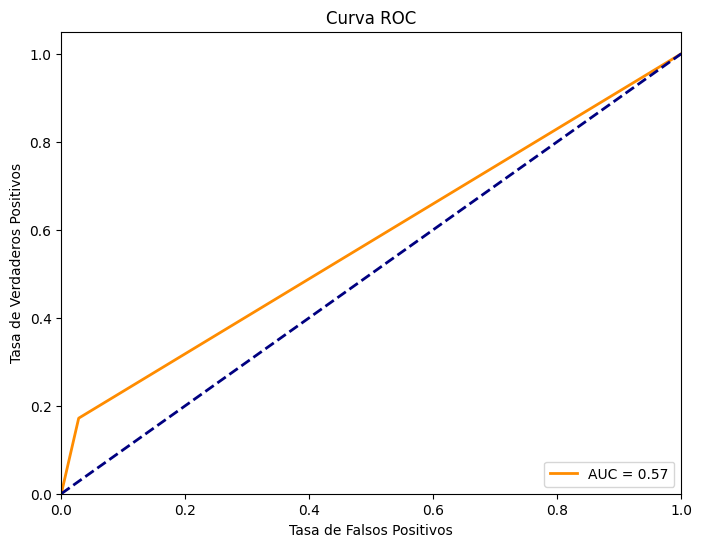

In [ ]:
fpr, tpr, _ = roc_curve(y_test, pred_lightgbm)

# Calcula el AUC-ROC
roc_auc = auc(fpr, tpr)

# Dibuja la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

###Análisis de resultados

In [ ]:
print(classification_report(y_test, pred_lightgbm))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11287
           1       0.20      0.17      0.19       466

    accuracy                           0.94     11753
   macro avg       0.58      0.57      0.58     11753
weighted avg       0.94      0.94      0.94     11753



###Predicción de casos de riesgo

In [ ]:
pred_lightgbm_riesgo = lightgbm_final.predict(X_test)

# Establecer un umbral para definir "alto riesgo" (por ejemplo, 0.7)
umbral = 0.7
casos_alto_riesgo = (pred_lightgbm_riesgo > umbral)

# Evaluar el rendimiento del modelo en el conjunto de prueba completo
precision = precision_score(y_test, pred_lightgbm_riesgo > umbral)
recall = recall_score(y_test, pred_lightgbm_riesgo > umbral)
f1 = f1_score(y_test, pred_lightgbm_riesgo > umbral)
confusion = confusion_matrix(y_test, pred_lightgbm_riesgo > umbral)

# Imprimir los resultados
print(f"Casos de alto riesgo identificados: {casos_alto_riesgo.sum()}")
print(f"Precisión en casos de alto riesgo: {precision:.2f}")
print(f"Recall en casos de alto riesgo: {recall:.2f}")
print(f"Puntuación F1 en casos de alto riesgo: {f1:.2f}")
print("Matriz de Confusión en casos de alto riesgo:")
print(confusion)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Casos de alto riesgo identificados: 397
Precisión en casos de alto riesgo: 0.20
Recall en casos de alto riesgo: 0.17
Puntuación F1 en casos de alto riesgo: 0.19
Matriz de Confusión en casos de alto riesgo:
[[10970   317]
 [  386    80]]
